In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Plots, Measures, LsqFit
using Statistics, SpecialFunctions, StatsBase
using Random, Distributions
using LinearAlgebra
using FHist

In [3]:
include("./Data_Input.jl")
using .DataImport

include("./Distributions.jl")
using .PlotDistributions

include("./models.jl")
using .GenerativeModels

In [4]:
sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e3);

### Slide 1

In [5]:
# data = sep_data["M3"]["ORALCAVITY"]

# data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

# otus = unique(data.otu_id)
# max_day = maximum(data.experiment_day) + 1
# otu_groups = groupby(data, :otu_id)

# y = zeros(max_day, length(otus))
# env_data = []
# otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

# for g in otu_groups
#     otu = g.otu_id[1]
#     i = otu_index[otu]
#     for (t, fval) in zip(g.experiment_day, g.f)
#         if 1 <= t+1 <= max_day
#             y[t+1, i] = fval
#         end
#     end

#     y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#     push!(env_data, y[:,i])
# end

# matrix_data = hcat(env_data...);

# colors = palette(:tab10, 10)

# fig = plot(xlabel="day", ylabel="abundance", yrange=(0,0.004), size=(700,300), margin=5mm)
# range = 130:135
# for i in 2:4
#     c = colors[i-1]
#     plot!(fig, range, matrix_data[range, i], label=nothing, color=c)
#     scatter!(fig, range, matrix_data[range, i], label="OTU $(i-1)", color=c)
# end
# display(fig)
# savefig("./Images/time_series2.png")

### Slide 2

In [6]:
# AFDs = plot(yscale=:log10, xlabel="log(abundance)", ylabel="pdf", legend=:topleft, yrange=(1e-10, 1e0), xrange=(-6,3), title="AFD")
# TAYLORs = plot(xlabel="log(means)", ylabel="log(variances)", title="Taylor's Law", legend=:topleft)
# MADs = plot(yscale=:log10, xlabel="log(abundance)", ylabel="pdf", legend=:bottomleft, yrange=(1e-5, 5e0), title="MAD")

# betas = []
# means = []
# stds = []
# hmeans = []
# hstds = []
# centers = []
# values = []
# for (key, sub_data) in sep_data
#     for (subkey, data) in sub_data

#         data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

#         otus = unique(data.otu_id)
#         max_day = maximum(data.experiment_day) + 1
#         otu_groups = groupby(data, :otu_id)

#         y = zeros(max_day, length(otus))
#         env_data = []
#         otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

#         for g in otu_groups
#             otu = g.otu_id[1]
#             i = otu_index[otu]
#             for (t, fval) in zip(g.experiment_day, g.f)
#                 if 1 <= t+1 <= max_day
#                     y[t+1, i] = fval
#                 end
#             end

#             y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#             push!(env_data, y[:,i])
#         end

#         matrix_data = hcat(env_data...)
#         missing_thresh = Int64(floor(size(matrix_data, 1) / 1))
        
#         afd = PlotDistributions.make_AFD(matrix_data; missing_thresh=missing_thresh, Δb=0.2, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey", min_y_range=1e-6)
#         scatter!(AFDs, afd["hist"][1], afd["hist"][2], label="$key $subkey")
#         push!(betas, afd["params"]["β"])
#         push!(means, afd["params"]["μ_x"])
#         push!(stds, afd["params"]["σ_x"])
#         push!(hmeans, afd["hparams"]["μ"])
#         push!(hstds, afd["hparams"]["σ"])

#         taylor = PlotDistributions.make_Taylor(matrix_data; missing_thresh=missing_thresh, Δb=0.2, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
#         scatter!(TAYLORs, taylor["hist"][1], taylor["hist"][2], label="$key $subkey")
#         push!(centers, taylor["hist"][1])
#         push!(values, taylor["hist"][2])

#         mad = PlotDistributions.make_MAD(matrix_data; missing_thresh=missing_thresh, Δb=0.5, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
#         scatter!(MADs, mad["hist"][1], mad["hist"][2], label="$key $subkey")
#     end
# end

In [7]:
# xarr = -6.0:0.05:2
# β = mean(betas)
# μ_x = mean(means)
# σ_x = mean(stds)
# μ = mean(hmeans)
# σ = mean(hstds)
# g_gamma = [10^(β*x - μ_x/σ_x^2*exp(x) - loggamma(β) + β*log(μ_x/σ_x^2)) for x in (xarr .* sqrt(2 * σ^2) .+ μ)]
# plot!(AFDs, xarr, g_gamma, color=:black, label="Gamma(β = $(round(β, digits=3)))", lw=1.5)
# display(AFDs)
# savefig("./Images/long_AFD_total.png")

In [8]:
# func(x, p) = p[1] .* x .+ p[2]
# p0 = [2.0, 0.0]  # Initial guess for the parameters
# fit = curve_fit(func, vcat(centers...), vcat(values...), p0)
# p_fit = fit.param

# bmin, bmax = extrema(vcat(centers...))
# xarr = bmin:0.01:bmax
# fitted_y = func(xarr, p_fit)
# if p_fit[2] >= 0
#     plot!(TAYLORs, xarr, fitted_y, color=:black, label="y = $(round(p_fit[1], digits=2))x + $(round(p_fit[2], digits=2))", lw=1.5)
# else
#     plot!(TAYLORs, xarr, fitted_y, color=:black, label="y = $(round(p_fit[1], digits=2))x - $(abs(round(p_fit[2], digits=2)))", lw=1.5)
# end
# display(TAYLORs)
# savefig("./Images/long_Taylor_total.png")

In [9]:
# xarr = -2.2:0.05:2.2
# lognorm = [10^(-x^2) for x in xarr]
# plot!(MADs, xarr, lognorm, color=:black, label="Lognormal", lw=1.5)
# vline!(MADs, [-0.5], ls=:dash, c="red", lw=1.5, label=nothing)
# display(MADs)
# savefig("./Images/long_MAD_total.png")

### Slide 3

In [10]:
# LagCorrs = []
# PSDs = []

# for (key, sub_data) in sep_data
#     for (subkey, data) in sub_data

#         data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

#         otus = unique(data.otu_id)
#         max_day = maximum(data.experiment_day) + 1
#         otu_groups = groupby(data, :otu_id)

#         y = zeros(max_day, length(otus))
#         env_data = []
#         otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

#         for g in otu_groups
#             otu = g.otu_id[1]
#             i = otu_index[otu]
#             for (t, fval) in zip(g.experiment_day, g.f)
#                 if 1 <= t+1 <= max_day
#                     y[t+1, i] = fval
#                 end
#             end

#             y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
#             push!(env_data, y[:,i])
#         end

#         matrix_data = hcat(env_data...)

#         max_lag = Int64(floor(size(matrix_data, 1) / 4))
#         missing_thresh = Int64(floor(size(matrix_data, 1) / 3))
        
#         lagcorr = PlotDistributions.make_lagCorr(matrix_data; missing_thresh=missing_thresh, max_lag=max_lag, make_log=true, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
#         push!(LagCorrs, lagcorr)

#         psd = PlotDistributions.make_PSD(matrix_data; missing_thresh=missing_thresh, freq_range=(-2, -0.5), make_log=true, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
#         push!(PSDs, psd)
#     end
# end

In [11]:
# figs = [lagcorr["fig"] for lagcorr in LagCorrs]
# combined_fig = plot(figs...;
#     layout=(2, 4),
#     size=(1500, 800),
#     margin=5mm,  # or try 10mm
#     guidefont=10,
#     tickfont=8,
#     legendfontsize=7,
# )
# display(combined_fig)
# savefig("./Images/long_autocorr.png")

In [12]:
# figs = [psd["fig"] for psd in PSDs]
# combined_fig = plot(figs...;
#     layout=(2, 4),
#     size=(1500, 800),
#     margin=5mm,  # or try 10mm
#     guidefont=10,
#     tickfont=8,
#     legendfontsize=7,
# )
# display(combined_fig)
# savefig("./Images/long_PSD.png")

### Slide 4

In [13]:
# # Set global parameters
# N_species = 500
# Δt = 0.01
# n = 250000
# ϵ = 1e-9
# skip=1

# Random.seed!(1234)

# # Set conditions for temporal analysis
# K = 100 .* rand(LogNormal(), N_species)
# # Pass y0 = K to the model so it is already at staedy state

# # Solve model
# data = GenerativeModels.logistic_growth(N_species, K, Δt, n; r=1.0, K=K, σ=1.0, ε=ϵ, skip=skip)
# println("Extincted species: ", count(iszero.(data[end,:])))

In [14]:
# colors = palette(:tab10, 10)

# # Create the initial plot
# fig = plot(xlabel="time step", ylabel="abundance",
#            yrange=(0, 500), size=(600, 250), margin=5mm)

# # Loop to plot lines and scatter points
# tau = 500
# time = 1:size(data[end-5000:tau:end, :], 1)
# for i in 1:4
#     plot!(fig, time .* 100, data[end-5000:tau:end, i], label=nothing, c=colors[i])
#     scatter!(fig, time .* 100, data[end-5000:tau:end, i], label=nothing, c=colors[i])
# end

# display(fig)
# savefig("./Images/SLM_time_series_skip.png")

In [15]:
# Compute distributions
# data_skip = data[1:tau:end, :]
# max_lag = Int64(floor(size(data_skip,1) / 10))
# afd = PlotDistributions.make_AFD(data_skip; Δb=0.2, plot_fig=true, plot_title="AFD", data_label="simulation")
# taylor = PlotDistributions.make_Taylor(data_skip; Δb=0.2, plot_fig=true, plot_title="Taylor's law", data_label="simulation")
# mad = PlotDistributions.make_MAD(data_skip; Δb=0.5, plot_fig=true, plot_title="MAD", data_label="simulation")
# lagcorr = PlotDistributions.make_lagCorr(data_skip; max_lag=max_lag, make_log=true, plot_fig=true, plot_title="Auto-Correlation", data_label="simulation")
# psd = PlotDistributions.make_PSD(data_skip; Δt=Δt*tau, freq_range=(-1.6, -0.5), make_log=true, plot_fig=true, plot_title="Power Spectrum Density", data_label="simulation")

# fig = afd["fig"]
# display(fig)
# savefig(fig, "./Images/SLM_AFD_skip500.png")

# fig = taylor["fig"]
# display(fig)
# savefig(fig, "./Images/SLM_Taylor_skip500.png")

# fig = mad["fig"]
# display(fig)
# savefig("./Images/SLM_MAD_skip500.png")

# fig = lagcorr["fig"]
# display(fig)
# savefig("./Images/SLM_autocorr_skip500.png")

# fig = psd["fig"]
# display(fig)
# savefig("./Images/SLM_PSD_skip500.png")

### Slide 6

In [16]:
# # Set global parameters
# N_species = 500
# Δt = 0.01
# n = 250000
# ε = 1e-6
# skip=1

# Random.seed!(1234)

# # Set conditions for temporal analysis
# K = 1000 .* rand(LogNormal(), N_species)
# ρ = 1 / (N_species*sqrt(N_species))
# A = GenerativeModels.sparse_gaussian_matrix(K, ρ; μ=-2/N_species, σ=1/N_species)

# # Solve model
# data = GenerativeModels.lotka_volterra(N_species, K, Δt, n; r=1.0, A=Matrix(A), σ=1.0, ε=ε, skip=1)
# println("Extincted species: ", count(iszero.(data[end,:])))

In [17]:
# lags = [0]
# data1 = data[end-2000:end,:]
# data2 = data[1:10:end, :]
# data2 = data2[end-2000:end, :]
# data3 = data[1:50:end, :]
# data3 = data3[end-2000:end, :]
# data4 = data[1:100:end, :]
# data4 = data4[end-2000:end, :]
# data5 = data[1:500:end, :]

# cross1 = PlotDistributions.make_lagCrossCorr(data1; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross2 = PlotDistributions.make_lagCrossCorr(data2; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross3 = PlotDistributions.make_lagCrossCorr(data3; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross4 = PlotDistributions.make_lagCrossCorr(data4; missing_thresh=500, Δb=0.05, lags=lags, make_log=true, plot_fig=false)
# cross5 = PlotDistributions.make_lagCrossCorr(data5; missing_thresh=125, Δb=0.05, lags=lags, make_log=true, plot_fig=false)

In [18]:
# fig = plot(xlabel="cross correlation", title="Cross-Correlation (lag=0)")
# crosses = [cross1["cross_corrs"], cross2["cross_corrs"], cross3["cross_corrs"], cross4["cross_corrs"], cross5["cross_corrs"]]
# skips = [1, 10, 50, 100, 500]
# for (i, mat) in enumerate(crosses)
#     bmin = -1
#     bmax = 1
#     hist_input = filter(!isnan, mat[1])
#     fh = FHist.Hist1D(hist_input, binedges=bmin:0.05:bmax) |> FHist.normalize
#     shadow = (length(crosses) - i + 1) / length(crosses)
#     plot!(fig, fh, label="skip = $(skips[i])", alpha=shadow)
# end

# display(fig)

### Slide 7

In [32]:
# Set global parameters
N_species = 500
Δt = 0.01
n = 250000
ε = 1e-4
skip=500

Random.seed!(1234)

# Set conditions for temporal analysis
K = 1000 .* rand(LogNormal(), N_species)
y0 = 1000 .* rand(N_species)
ρs = [0, 1/(N_species*sqrt(N_species)), 1/N_species, 0.1]

A = GenerativeModels.sparse_gaussian_matrix(K, ρs[3]; μ=-2/N_species, σ=1/N_species)
# Solve model
data = GenerativeModels.lotka_volterra(N_species, y0, Δt, n; r=1.0, A=Matrix(A), σ=1.0, ε=ε, skip=500);


In [33]:
minimum(data)

0.0

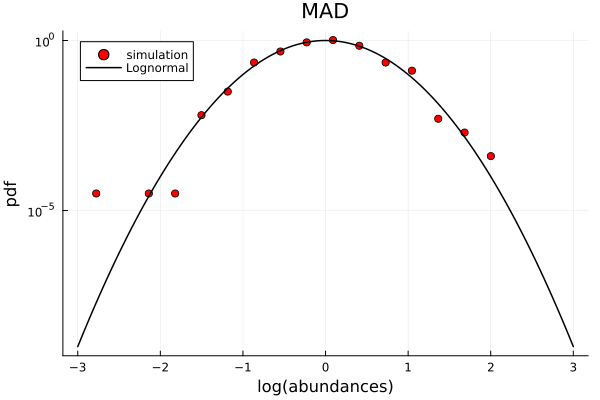

In [34]:
log_data = [log(mean(x)) for x in eachcol(data)]

bmin = floor(minimum(log_data))
bmax = ceil(maximum(log_data))
Δb = 0.5
fh = FHist.Hist1D(log_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i] * sqrt(2 * π * σ^2)) for i in eachindex(norm_counts[norm_counts.>0.0])]
centers = centers[norm_counts.>0.0]

xarr = -3.0:0.05:3.0
lognorm = [10^(-x^2) for x in xarr] # Gaussian distribution

fig = plot(yscale=:log10, xlabel="log(abundances)", ylabel="pdf", title="MAD", legend=:topleft)
scatter!(fig, centers, yy, color=:red, label="simulation")
plot!(fig, xarr, lognorm, color=:black, label="Lognormal", lw=1.5)
display(fig)